In [1]:
import numpy as np # NumPy
import matplotlib.pylab as plt # Matplotlib plots
import matplotlib.patches as mpatches
import matplotlib.colors as colors
import mpl_scatter_density     # density scatter plots
import pandas as pd # Pandas
import uproot
import pickle
import logging
import gc

import os # read directories etc.
from scipy.signal import find_peaks, gaussian
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde
import pylandau

import time
from timeout_decorator import timeout

from importlib import reload # to reload modules
import LoadBatch
reload(LoadBatch)
from LoadBatch import *
from SensorClasses import *

In [2]:
pd.set_option('display.max_columns', None)
# logging.basicConfig(level=logging.WARNING, format='[%(levelname)s] - %(message)s')
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] - \t %(message)s')
# plt.rcParams['text.usetex'] = True   ### LateX in matplotlib
# !ls ../Data_TestBeam/2023_May/

In [3]:
# plt.style.use(hep.atlas.style.ATLAS)

### Bins options, sensors and runs import

In [4]:
# PIXEL_SIZE = 0.0184 #mm

### this should not be necessary anymore, moved into LoadBatch.py
### choose the bins so that they match the MIMOSA pixels (which are just the coordinates)

### Load the dictionary of sensor names and runs
# dict_of_runs = read_pickle("dict_of_runs.pickle")
dict_of_batches = read_pickle("/home/marcello/Desktop/Radboud_not_synchro/Master_Thesis/testbeam-analysis/dict_of_batches.pickle")


# ### presentation path
pres_path = '/home/marcello/Desktop/Radboud_not_synchro/Master_Thesis/Presentations/2024-02-15 for fast-silicon-pixel'

ROOT_fit_dir = f"/home/marcello/Desktop/Radboud_not_synchro/Master_Thesis/testbeam-analysis/ROOT Langaus fit/"

In [5]:
list_of_batches = list(dict_of_batches.keys())
list_of_batches.sort()
print(list_of_batches)

[100, 101, 199, 201, 202, 203, 204, 205, 206, 301, 401, 402, 403, 406, 407, 408, 409, 410, 411, 413, 414, 501, 502, 504, 505, 601, 602, 603, 604, 605, 701, 702, 801, 802, 901, 902, 1001, 1002, 1101, 1102, 1201, 1202, 5031, 5032]


## Plot a single batch or multiple batches in a row
(just put the a list, or one, of the batches to plot in `for this_batch in []:`)

In [6]:
start = time.time()
### show all information about the batch
SAVE = True
show_plot = False

colormap = ['k','b','g','r']

binning_method = 'rice'
threshold_charge = 4 #fC
charge_bins = 500
eff_lim = (0.4,1)
# MCP_resolution = 36.52
time_bins = 4000
window_limit = 20e3
n_bootstrap = 50
CFD_values = (20, 50, 70)
axes_size = len(CFD_values)

for this_batch in [100, 101, 199]:

    dir_path = f'/home/marcello/Desktop/Radboud_not_synchro/Master_Thesis/various plots/all batches/{this_batch}'

    display(dict_of_batches[this_batch].__dict__)
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

    info_dict = {}
    ### show all informations about each sensor
    for S in ['S1','S2']:
        if dict_of_batches[this_batch].S[S] is None:
            logging.warning(f"No oscilloscope {S} in batch {this_batch}")
            info_dict[(S,ch)] = None
        else:
            for ch, sensor in dict_of_batches[this_batch].S[S].channels.items():
        #         print(f"{S}, {ch}:", sensor.__dict__)
                info_dict[(S,ch)] = sensor.__dict__
    info_df = pd.DataFrame(info_dict)
    display(info_df)
    # Export DataFrame to a CSV file
    info_df.to_csv(os.path.join(dir_path,f'table_data_{this_batch}.csv'), index=True)
   
    print("Batch: ", this_batch)

    ### save in a presentation folder
    # dir_path = pres_path

    df = {}  # dictionary containing the two dataframes of the two oscilloscopes
    # 'pulseheight' or 'time'
    if this_batch in [502, 601, 602, 603, 604, 605, 901, 902, 1001, 1002]:
        use_for_geometry_cut = 'time'
    else:
        use_for_geometry_cut = 'pulseheight' 

    these_bins = bins_dict[this_batch] #bins1    ### custom bins around the sensors
    
    for S in ['S1','S2']: #"S2" ### the two scopes
        print(S)
        
        DUTs = get_DUTs_from_dictionary(info_dict,S)
#         DUTs = [2]
        if not DUTs: continue   ### if there are no DUTs in this oscilloscope just go to next

        df[S] = load_batch(this_batch,S)
        print(f'MCP: {dict_of_batches[this_batch].S[S].channels["Ch1"].voltage} V, angle: {dict_of_batches[this_batch].angle}°', 'temperature:%.2f°C'%dict_of_batches[this_batch].temperature)

        ## show full area
        plot(df[S], "2D_Tracks", dict_of_batches[this_batch], S, bins=large_bins,
             n_DUT=DUTs, savefig=SAVE, savefig_details=f' {S} all tracks (no cut)', savefig_path=dir_path, fmt='png', show_plot=show_plot)  
        
        ### I PUT THE TRANSIMPEDANCE TO 4700 MANUALLY
        my_transimpedance = 4700 #4700 or 10700

#         ###[ ... if dut in DUTs else None for dut in [1,2,3]], it avoids calculating the cuts for the channels with no dut
#         geo_cuts = [geometry_mask(df[S], DUT_number=dut, bins=these_bins, bins_find_min='rice', use=use_for_geometry_cut)[0] if dut in DUTs else None for dut in [1,2,3]]
#         central_sensor_area_cuts = [geometry_mask(df[S], DUT_number=dut, bins=these_bins, bins_find_min='rice', only_select='center', use=use_for_geometry_cut)[0] if dut in DUTs else None for dut in [1,2,3]]
#         time_cuts = [time_mask(df[S], dut, bins=time_bins, mask=geo_cuts[dut-1], n_bootstrap=False, plot=False, savefig=os.path.join(dir_path,f'time_plot_with_geo_cuts_{S}_{this_batch}_DUT{dut}.png'))[0] if dut in DUTs else None for dut in [1,2,3]]
#         charge_cut = [df[S][f'charge_{dut}']/my_transimpedance>threshold_charge if dut in DUTs else None for dut in [1,2,3]]
        
#         ### time resolution fit
#         [time_mask(df[S], dut, bins=time_bins, n_bootstrap=n_bootstrap, mask=np.logical_and(geo_cuts[dut-1],charge_cut[dut-1]), plot=True,
#                                      savefig=os.path.join(dir_path,f'time_plot_with_geo_cuts_{S}_{this_batch}_DUT{dut}.png'))[1]['parameters'] if dut in DUTs else None for dut in [1,2,3]]
#         ### time resolution fit with central area cuts
#         [time_mask(df[S], dut, bins=time_bins, n_bootstrap=n_bootstrap, mask=np.logical_and(central_sensor_area_cuts[dut-1],charge_cut[dut-1]), plot=True, title_info=' center cut',
#                                      savefig=os.path.join(dir_path,f'time_plot_with_center_cuts_{S}_{this_batch}_DUT{dut}.png'))[1]['parameters'] if dut in DUTs else None for dut in [1,2,3]]
    
#         ### I still need pulseHeight cut for the charge fit
#         mins = [find_min_btw_peaks(df[S][f"pulseHeight_{dut}"], bins='rice', plot=False) if dut in DUTs else None for dut in [1,2,3]]
#         pulse_cuts = [df[S][f'pulseHeight_{dut}']>mins[dut-1] if dut in DUTs else None for dut in [1,2,3]]
#         for dut in [1,2,3]:
#             if (pulse_cuts[dut-1] is not None) and (np.alltrue(pulse_cuts[dut-1]==False)):
#                 pulse_cuts[dut-1] = pd.Series(True, index=df[S].index)
#             if use_for_geometry_cut == "time":   ### also NOT APPLY a pulseHeight cut if I choose time for geometry cut
#                 pulse_cuts[dut-1] = pd.Series(True, index=df[S].index)
#         ### charge distribution with cuts saved into a file and the fitted with ROOT Landau*Gauss convolution
#         all_cuts = [np.logical_and(np.logical_and(geo_cuts[dut-1], time_cuts[dut-1]), pulse_cuts[dut-1]) 
#                     if dut in DUTs else None for dut in [1,2,3]]
#         for dut in DUTs:
# #             np.savetxt(os.path.join(dir_path, f"charge_data_all_cuts_{this_batch}_{S}_{dut}.csv"),
# #                        df[S][f'charge_{dut}'].loc[all_cuts[dut-1]]/my_transimpedance, delimiter=',')
#             os.chdir(ROOT_fit_dir)
#             run_root_string = f'root -b -q "charge_fit.C({this_batch},\\"{S}\\",{dut})"'
#             os.system(run_root_string)
            
        ### highlight the sensors with pulseHeight cut
#         plot(df[S], "2D_Sensors", dict_of_batches[this_batch], S, bins=these_bins, bins_find_min=binning_method,
#              n_DUT=DUTs, savefig=SAVE, savefig_details=f' {S} (pulseHeight cut)', savefig_path=dir_path, fmt='png')    
#         ### highlight the sensors with time cut
#         plot(df[S], "2D_Tracks", dict_of_batches[this_batch], S, bins=these_bins, mask=time_cuts,
#              n_DUT=DUTs, savefig=SAVE, savefig_details=f' {S} (w. time cut)', savefig_path=dir_path, fmt='png')
#         # delta time vs pulseHeight w/ info
#         plot(df[S], "Time_pulseHeight", dict_of_batches[this_batch], S, bins=time_bins,
#              n_DUT=DUTs, savefig=SAVE, savefig_details=f' {S} ', savefig_path=dir_path, fmt='png')
#         ### delta time vs pulseHeight no info
#         plot(df[S], "Time_pulseHeight", dict_of_batches[this_batch], S, bins=time_bins, info=False, extra_info=False,
#              n_DUT=DUTs, savefig=SAVE, savefig_details=f' {S} no info', savefig_path=dir_path, fmt='png') 
#         ### delta time vs pulseHeight central area no info
#         plot(df[S], "Time_pulseHeight", dict_of_batches[this_batch], S, bins=time_bins, info=False, extra_info=False, mask=central_sensor_area_cuts,
#              n_DUT=DUTs, savefig=SAVE, savefig_details=f' {S} central area', savefig_path=dir_path, fmt='png')
#         ### efficiency projection whole sensor (zooomed)
#         plot(df[S], "1D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, transimpedance=my_transimpedance, geometry_cut='normal', use=use_for_geometry_cut, zoom_to_sensor=True, efficiency_lim=eff_lim,
#             bins=these_bins, bins_find_min=binning_method, n_DUT=DUTs, savefig=SAVE, savefig_details=f' {S} threshold charge {threshold_charge}fC', savefig_path=dir_path)
#         ### with time cut in the center (zoomed)
#         plot(df[S], "1D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, transimpedance=my_transimpedance, geometry_cut='center', use=use_for_geometry_cut, mask=time_cuts, zoom_to_sensor=True, efficiency_lim=eff_lim,
#             bins=these_bins, bins_find_min=binning_method, n_DUT=DUTs, savefig=SAVE, savefig_details=f' {S} threshold charge {threshold_charge}fC (center and time cut)', savefig_path=dir_path)
#         ### 2D efficiency
#         plot(df[S], "2D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, transimpedance=my_transimpedance, geometry_cut='normal', use=use_for_geometry_cut, zoom_to_sensor=True,
#             bins=these_bins, bins_find_min=binning_method, n_DUT=DUTs, savefig=SAVE, savefig_details=f' {S} thresh charge {threshold_charge}fC', savefig_path=dir_path, fmt='png')
#         ### with time cut and zoomed
#         plot(df[S], "2D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, transimpedance=my_transimpedance, geometry_cut='normal', use=use_for_geometry_cut, mask=time_cuts, zoom_to_sensor=True,
#             bins=these_bins, bins_find_min=binning_method, n_DUT=DUTs, savefig=SAVE, savefig_details=f' {S} thresh charge {threshold_charge}fC (center and time cut)', savefig_path=dir_path, fmt='png')    
#         plt.close('all')
#     ### CFD values comparison with normal geo cuts
#         CFD_mask = [np.logical_and(charge_cut[dut-1], geo_cuts[dut-1]) if dut in DUTs else None for dut in [1,2,3]]
#         for dut in DUTs:
#             fig, _ = plot(df[S], 'CFD_comparison', dict_of_batches[this_batch], S, n_DUT=dut, CFD_values=CFD_values, mask=CFD_mask, time_bins=time_bins,
#                  savefig=SAVE, savefig_path=dir_path, savefig_details=f" geo cuts")
#             plt.close(fig)
#     ### CFD values comparison with central area cuts (less statistics)
#         CFD_mask = [np.logical_and(charge_cut[dut-1], central_sensor_area_cuts[dut-1]) if dut in DUTs else None for dut in [1,2,3]]
#         for dut in DUTs:
#             fig, _ = plot(df[S], 'CFD_comparison', dict_of_batches[this_batch], S, n_DUT=dut, CFD_values=CFD_values, mask=CFD_mask,
#                  savefig=SAVE, savefig_path=dir_path, savefig_details=f" central area cuts")
#             plt.close(fig)
#         print(df['S1'].memory_usage(deep=True))
    del df['S1']
    del df['S2']
    del df
    gc.collect()
#     df['S1'] = pd.DataFrame()
#     df['S2'] = pd.DataFrame()
    
stop = time.time()
print(f"TOTAL TIME: {(stop-start)//60:.0f} min and {(stop-start)%60:.2f} sec")

{'batch_number': 100,
 'angle': 0.0,
 'humidity': 2.2,
 'temperature': -32.87,
 'S': {'S1': <SensorClasses.Oscilloscope at 0x7f9cf3f713c0>,
  'S2': <SensorClasses.Oscilloscope at 0x7f9cf3f71c90>}}

S1                                      \
                     Ch1               Ch2               Ch3   
name                 MCP  IMEv3-W12-C2-2-2  IMEv3-W12-C2-2-2   
board           no_board            CERN-1            CERN-1   
dut_position         5.0               1.0               1.0   
fluence                0                 0                 0   
transimpedance        -1              4700              4700   
voltage             2500               -70               -70   
current         0.000069          0.000003          0.000003   

                                        S2                      \
                             Ch4       Ch1                 Ch2   
name            IMEv3-W12-C3-1-4       MCP  CNM-R15973-W5-D138   
board                     CERN-1  no_board             JSI-B14   
dut_position                   1       5.0                   4   
fluence                        0         0                   0   
transimpedance              4700        -1                4700   
voltage                      -70      2500                 -80   
current                 0.000003  0.000069                 0.0   

                                                      
                               Ch3               Ch4  
name            CNM-R15973-W4-D168  IMEv3-W12-C3-1-5  
board                      JSI-B12            CERN-1  
dut_position                     2               1.0  
fluence                          0                 0  
transimpedance                4700              4700  
voltage                        -80               -70  
current                        0.0          0.000003

[INFO] - 	 Loading batch 100 	 Oscilloscope S1


Batch:  100
S1
MCP: 2500 V, angle: 0.0° temperature:-32.87°C


[INFO] - 	 Loading batch 100 	 Oscilloscope S2


S2
MCP: 2500 V, angle: 0.0° temperature:-32.87°C


{'batch_number': 101,
 'angle': 0.0,
 'humidity': 2.3,
 'temperature': -33.45,
 'S': {'S1': <SensorClasses.Oscilloscope at 0x7f9cf3f72110>,
  'S2': <SensorClasses.Oscilloscope at 0x7f9cf3f724d0>}}

S1                                      \
                     Ch1               Ch2               Ch3   
name                 MCP  IMEv3-W12-C2-2-2  IMEv3-W12-C2-2-2   
board           no_board            CERN-1            CERN-1   
dut_position         5.0               1.0               1.0   
fluence                0                 0                 0   
transimpedance        -1              4700              4700   
voltage             2500               -80               -80   
current         0.000069          0.000004          0.000004   

                                        S2                      \
                             Ch4       Ch1                 Ch2   
name            IMEv3-W12-C3-1-4       MCP  CNM-R15973-W5-D138   
board                     CERN-1  no_board             JSI-B14   
dut_position                   1       5.0                   4   
fluence                        0         0                   0   
transimpedance              4700        -1                4700   
voltage                      -80      2500                 -80   
current                 0.000004  0.000069                 0.0   

                                                      
                               Ch3               Ch4  
name            CNM-R15973-W4-D168  IMEv3-W12-C3-1-5  
board                      JSI-B12            CERN-1  
dut_position                     2               1.0  
fluence                          0                 0  
transimpedance                4700              4700  
voltage                        -80               -80  
current                        0.0          0.000004

[INFO] - 	 Loading batch 101 	 Oscilloscope S1


Batch:  101
S1
MCP: 2500 V, angle: 0.0° temperature:-33.45°C


[INFO] - 	 Loading batch 101 	 Oscilloscope S2


S2
MCP: 2500 V, angle: 0.0° temperature:-33.45°C


{'batch_number': 199,
 'angle': nan,
 'humidity': 0.9800000000000001,
 'temperature': -31.2,
 'S': {'S1': <SensorClasses.Oscilloscope at 0x7f9d37e37100>,
  'S2': <SensorClasses.Oscilloscope at 0x7f9d37e37250>}}

S1                                      \
                     Ch1               Ch2               Ch3   
name                 MCP  IMEv3-W12-C2-2-2  IMEv3-W12-C2-2-2   
board           no_board            CERN-1            CERN-1   
dut_position         5.0               1.0               1.0   
fluence                0                 0                 0   
transimpedance        -1              4700              4700   
voltage             2600               -80               -80   
current             72.7          0.000004          0.000004   

                                        S2                      \
                             Ch4       Ch1                 Ch2   
name            IMEv3-W12-C3-1-4       MCP  CNM-R15973-W5-D138   
board                     CERN-1  no_board             JSI-B14   
dut_position                   1       5.0                   3   
fluence                        0         0                   0   
transimpedance              4700        -1                4700   
voltage                      -80      2600                 -80   
current                 0.000004      72.7                 0.0   

                                                      
                               Ch3               Ch4  
name            CNM-R15973-W4-D168  IMEv3-W12-C3-1-5  
board                      JSI-B12            CERN-1  
dut_position                     2               1.0  
fluence                          0                 0  
transimpedance                4700              4700  
voltage                        -80               -80  
current                        0.0          0.000004

[INFO] - 	 Loading batch 199 	 Oscilloscope S1


Batch:  199
S1
MCP: 2600 V, angle: nan° temperature:-31.20°C


[INFO] - 	 Loading batch 199 	 Oscilloscope S2


S2
MCP: 2600 V, angle: nan° temperature:-31.20°C
TOTAL TIME: 0 min and 27.89 sec


In [8]:
# geo_cuts = [geometry_mask(df[S], DUT_number=dut, bins=these_bins, bins_find_min='rice', use=use_for_geometry_cut)[0] if dut in DUTs else None for dut in [1,2,3]]
# geometry_mask(df['S1'], DUT_number=1, bins=these_bins, bins_find_min='rice', use=use_for_geometry_cut)

# df['S1']

In [20]:
geo_cuts[1].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1397077 entries, 0 to 1397076
Series name: None
Non-Null Count    Dtype
--------------    -----
1397077 non-null  bool 
dtypes: bool(1)
memory usage: 1.3 MB


In [12]:
%whos

Variable                      Type               Data/Info
----------------------------------------------------------
Batch                         type               <class 'SensorClasses.Batch'>
CFD_values                    tuple              n=3
DUTs                          list               n=3
LoadBatch                     module             <module 'LoadBatch' from <...>m-analysis/LoadBatch.py'>
NO_BOARD                      str                no_board
Oscilloscope                  type               <class 'SensorClasses.Oscilloscope'>
PIXEL_SIZE                    float              0.0184
ROOT_fit_dir                  str                /home/marcello/Desktop/Ra<...>nalysis/ROOT Langaus fit/
Rectangle                     type               <class 'matplotlib.patches.Rectangle'>
S                             str                S2
SAVE                          bool               True
Sensor                        type               <class 'SensorClasses.Sensor'>
axes_size    

NameError: name 'df' is not defined

## Plot a single run

In [19]:
# relevant batches: 413, 411
# relevant runs: 9767

# this_batch = 413
# dict_of_batches[this_batch].S['S1'].runs

[9761, 9762, 9763, 9764, 9769, 9775]

DUT_1
DUT_2


/home/marcello/.local/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/marcello/.local/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


(<Figure size 4800x2400 with 3 Axes>,
 array([<ScatterDensityAxesSubplot:title={'center':'DUT: USTC2.1-W17-P6-A'}, xlabel='$\\Delta t$ [ps] (DUT 1 - MCP)', ylabel='PulseHeight [mV]'>,
        <ScatterDensityAxesSubplot:title={'center':'DUT: USTC2.1-W17-P6-A'}, xlabel='$\\Delta t$ [ps] (DUT 2 - MCP)', ylabel='PulseHeight [mV]'>],
       dtype=object))

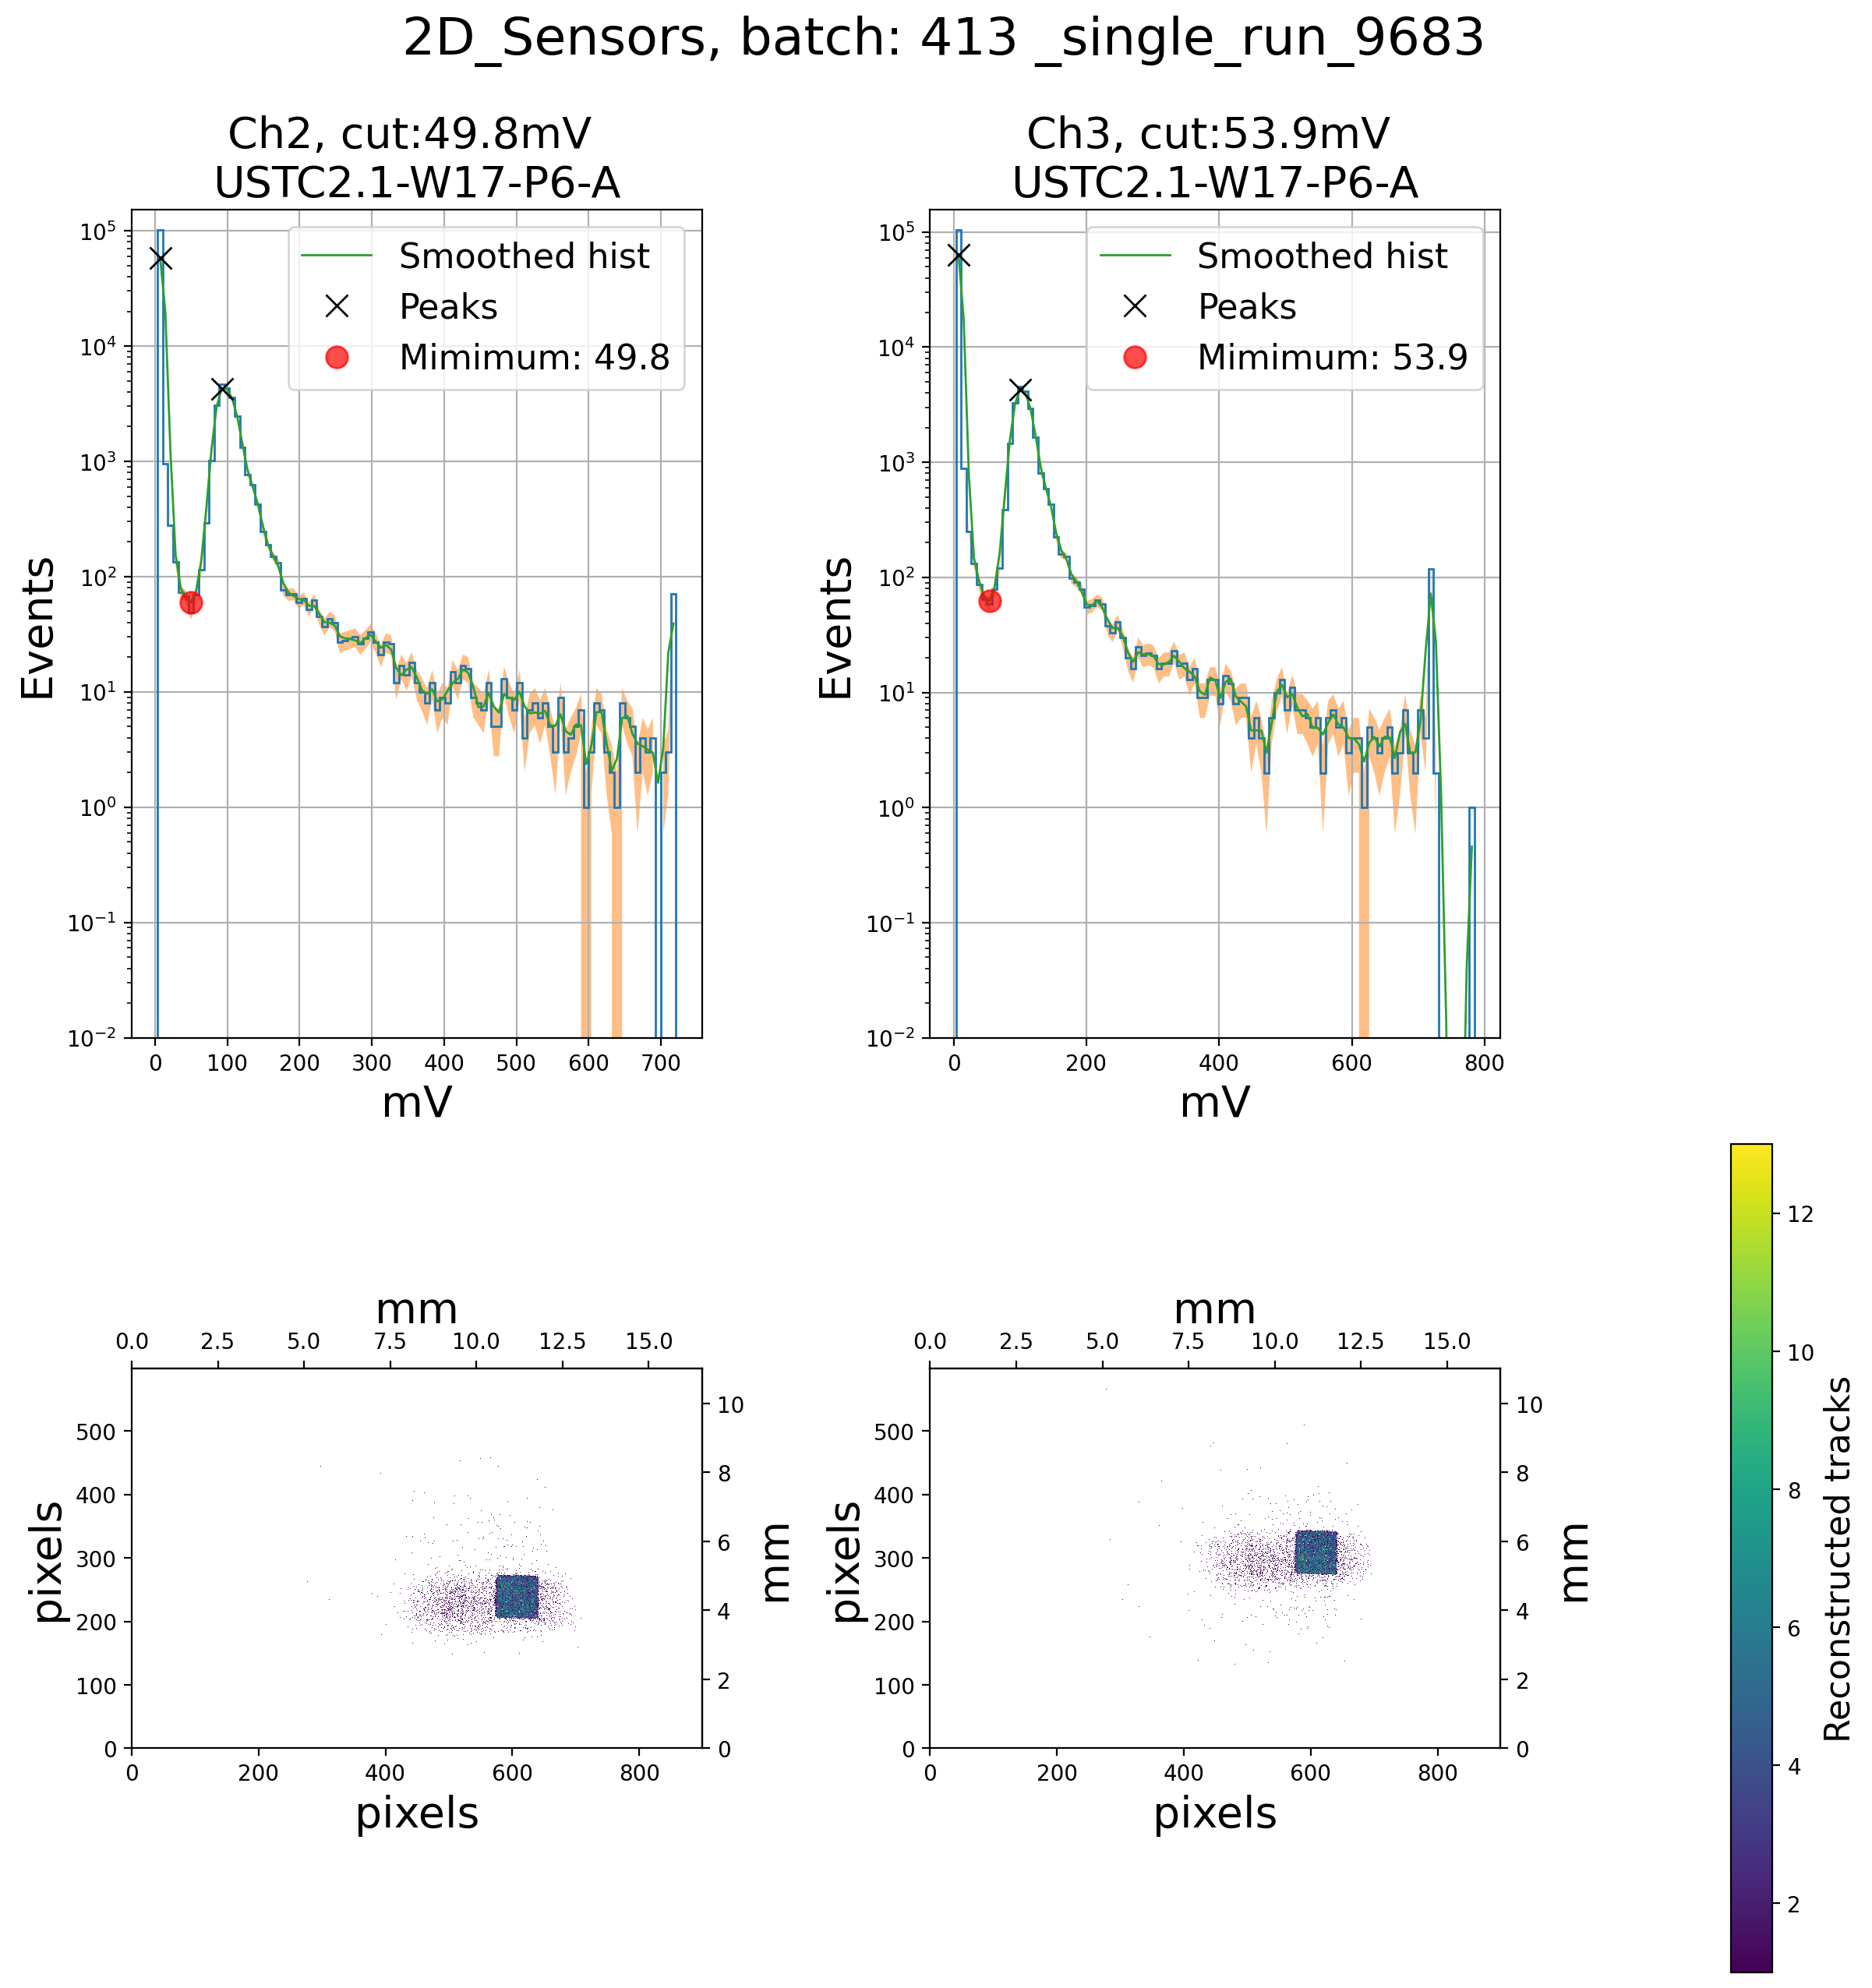

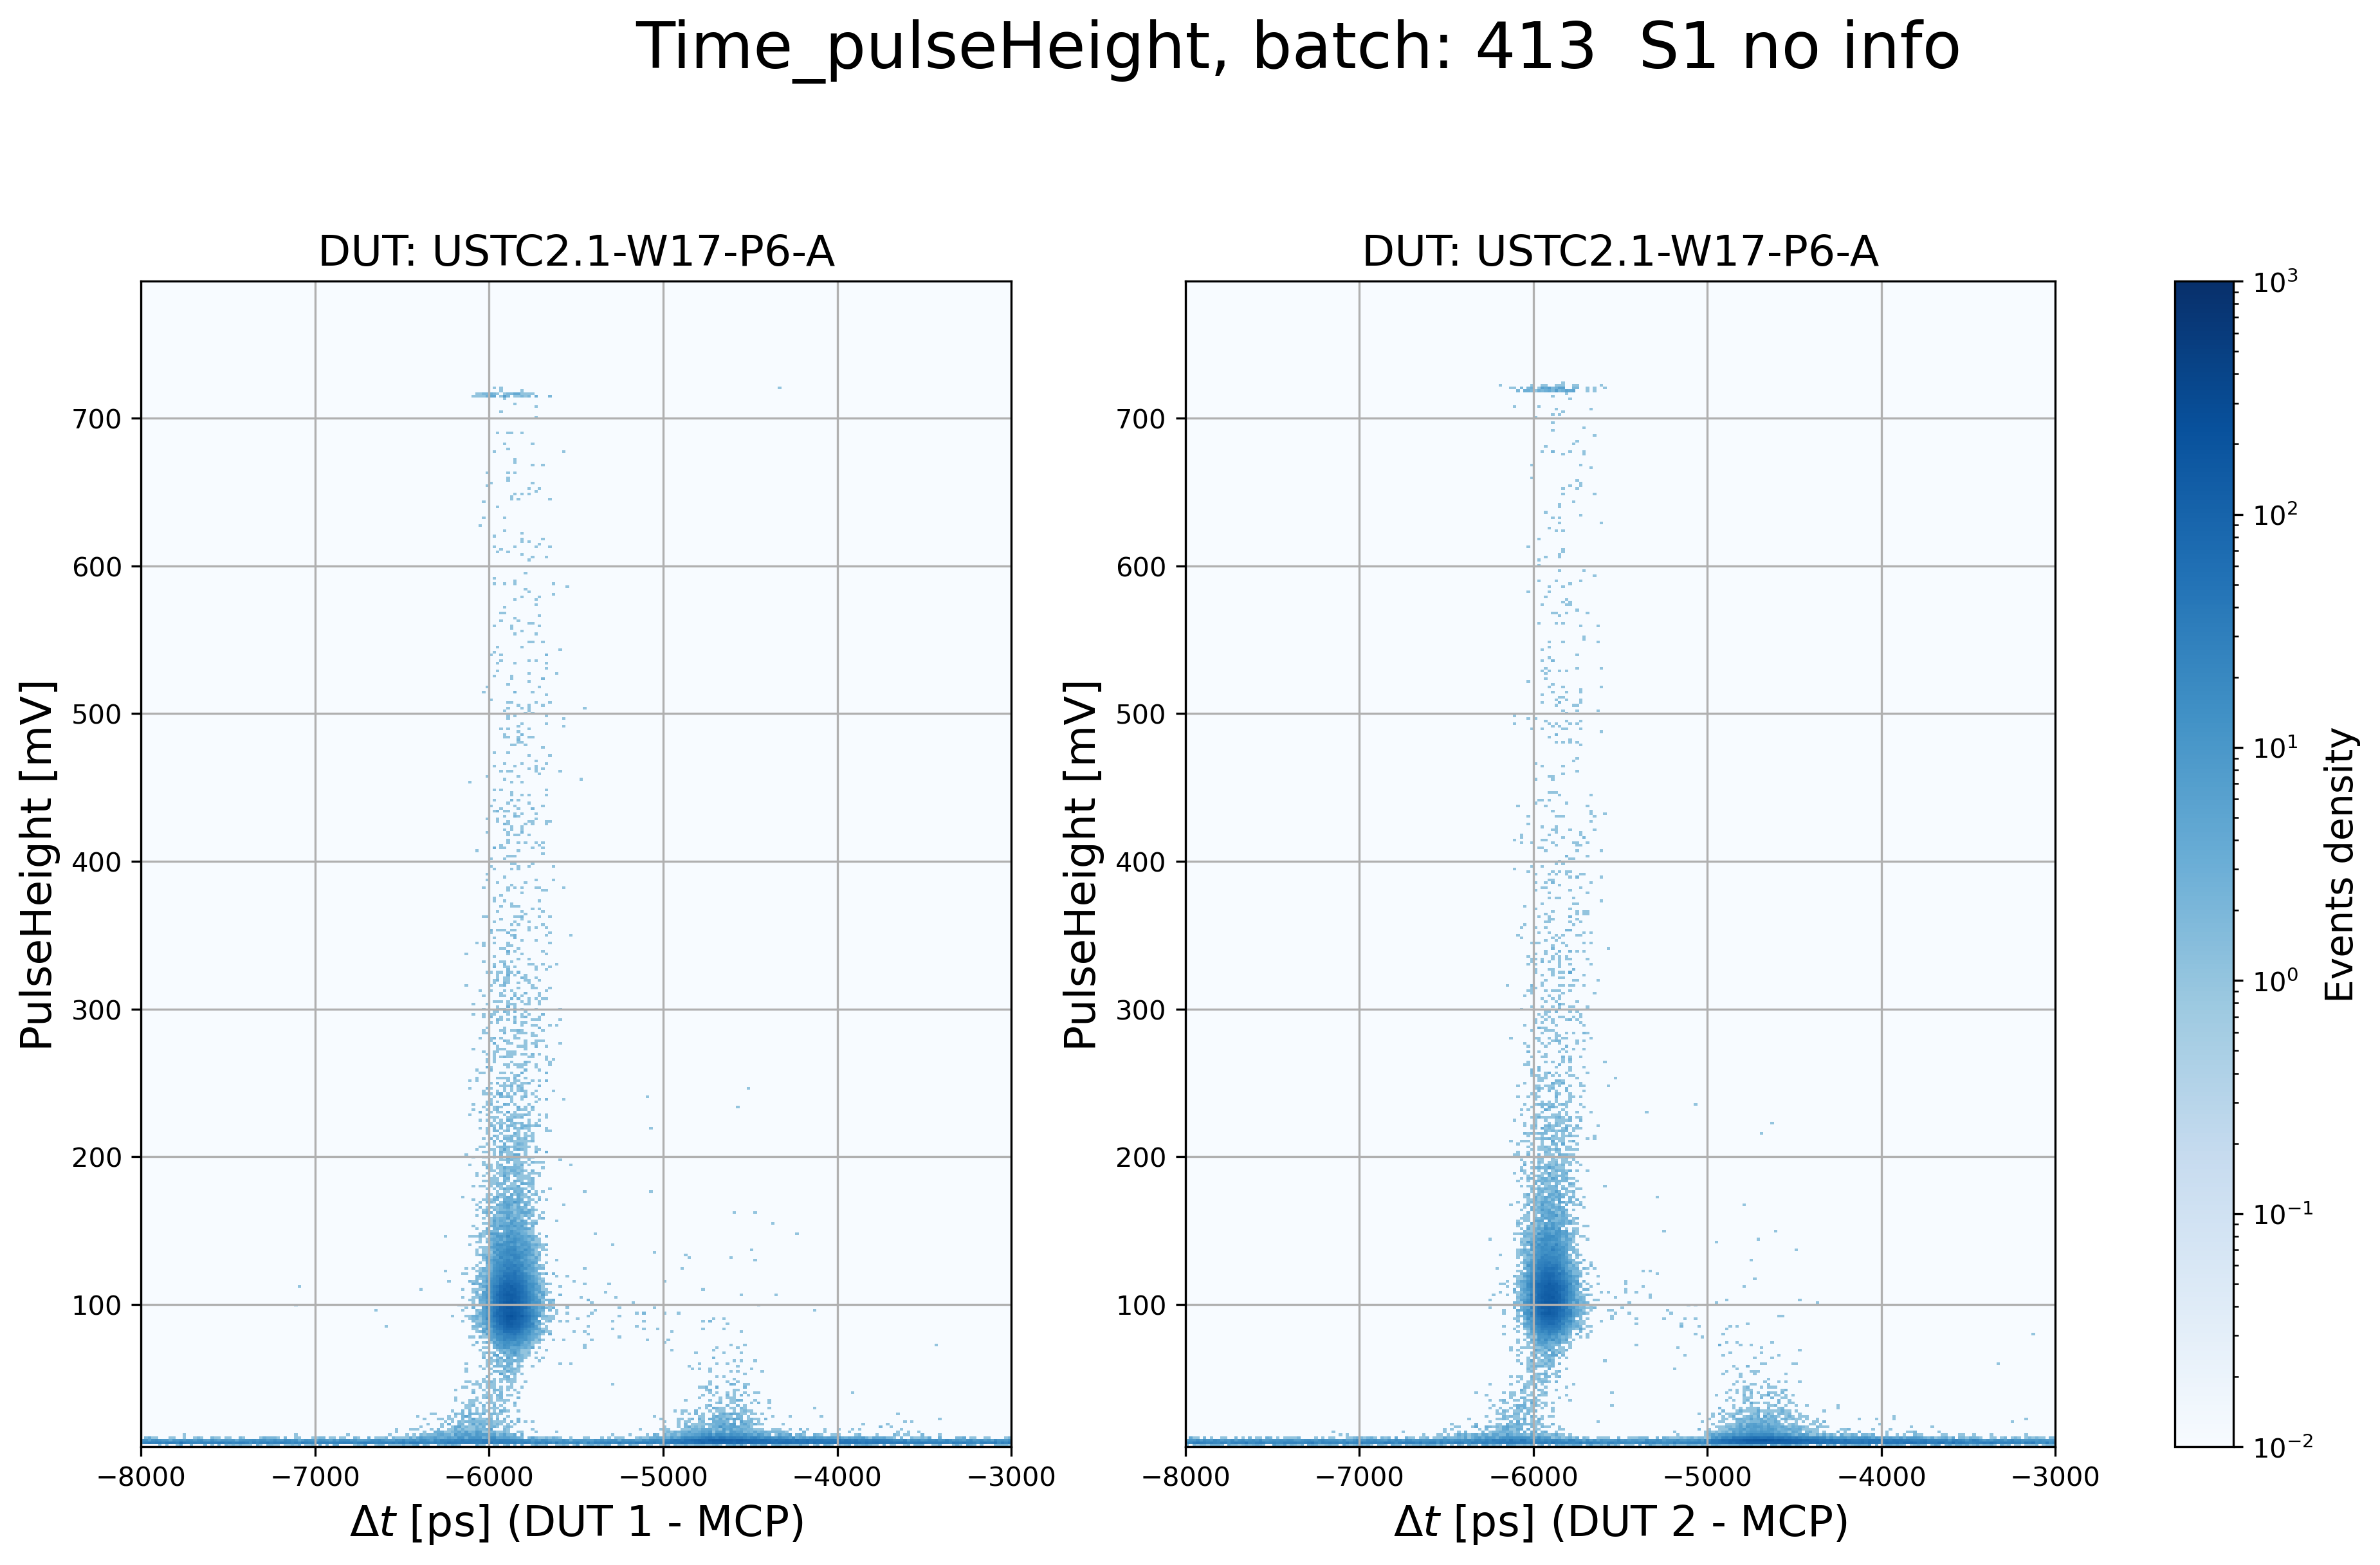

In [27]:
### looking at single runs 
S_run = 'S1'
dir_path = f"/home/marcello/Desktop/Radboud_not_synchro/Master_Thesis/Data_TestBeam/2023_May/{S_run}/"
run = 9683
DUTs = [1,2]

time_bins = 2000


if run>9999:    file_path = f"tree0{run}.root"
elif run<=9999: file_path = f"tree00{run}.root"

### branches to be loaded (+ unnecessary columns)
branches = ["eventNumber", "Xtr", "Ytr", "pulseHeight", "charge", "noise", "pedestal", "timeCFD20", "timeCFD50", "timeCFD70"]
columns_to_remove = ["Xtr_4","Xtr_5","Xtr_6","Xtr_7","Ytr_4","Ytr_5","Ytr_6","Ytr_7"]

try:
    df_run = root_to_df(os.path.join(dir_path, file_path), branches)
except FileNotFoundError:
    logging.error("Run file not found")

df_run = root_to_df(os.path.join(dir_path, file_path), branches)
df_run = df_run.drop(columns=columns_to_remove)
    
plot(df_run,"2D_Sensors", dict_of_batches[this_batch], S_run, bins=large_bins, n_DUT=DUTs,
    savefig=False, savefig_details=f"_single_run_{run}")
plot(df_run, "Time_pulseHeight", dict_of_batches[this_batch], S_run, bins=time_bins, info=False, extra_info=False,
     n_DUT=DUTs, savefig=False, savefig_details=f' {S_run} no info', savefig_path=dir_path, fmt='png') 
# plot(df["S2"],"2D_Tracks", batch=this_batch, sensors=sensors_list[this_batch]["S2"], bins=bins)

In [22]:
df_run

,eventNumber,Xtr_0,Xtr_1,Xtr_2,Xtr_3,Ytr_0,Ytr_1,Ytr_2,Ytr_3,pulseHeight_0,pulseHeight_1,pulseHeight_2,pulseHeight_3,charge_0,charge_1,charge_2,charge_3,noise_0,noise_1,noise_2,noise_3,pedestal_0,pedestal_1,pedestal_2,pedestal_3,timeCFD20_0,timeCFD20_1,timeCFD20_2,timeCFD20_3,timeCFD50_0,timeCFD50_1,timeCFD50_2,timeCFD50_3,timeCFD70_0,timeCFD70_1,timeCFD70_2,timeCFD70_3
0,3,521.778944,521.653588,520.741752,3.211427e-322,264.916334,265.020737,265.780161,3.211427e-322,3.634790,6.773303,6.450164,7.424149,2250.291748,560.164551,-887.008423,4548.617188,0.444964,2.530119,2.274119,1.455723,1.344072,8.858730,3.577780,1.520467,29695.705078,42841.191406,44569.980469,49045.234375,29925.023438,42880.253906,44603.500000,49185.460938,30007.445312,42906.296875,44636.281250,49315.953125
1,4,531.599765,531.706127,532.479798,3.211427e-322,343.622532,343.625611,343.648005,3.211427e-322,3.046102,7.020173,5.355247,4.873692,1352.631470,-5397.352539,-7493.910156,2512.273193,0.465434,2.141515,2.243737,1.519947,1.286731,8.884283,4.387311,1.911015,26096.599609,22392.294922,12680.813477,21370.951172,26248.654297,22420.927734,13065.449219,21480.177734,26308.099609,22440.017578,13113.784180,21741.277344
2,8,535.469841,535.473444,535.499647,3.211427e-322,291.780809,291.688911,291.020452,3.211427e-322,5.190244,8.414499,7.145441,3.758725,2181.541504,6837.206543,-806.622925,-0.000739,0.484721,2.102350,2.451256,1.257858,1.249308,8.618542,4.296505,2.306018,29374.009766,19657.970703,29452.119141,49805.812500,29581.105469,19716.408203,29485.570312,49856.320312,29658.058594,19760.710938,29507.871094,49856.320312
3,9,605.704251,605.628240,605.075340,3.211427e-322,327.604897,327.681962,328.242526,3.211427e-322,3.040075,6.082880,104.109421,3.715940,545.019653,1316.836426,123261.867188,1153.166748,0.445175,2.309777,1.872274,1.385301,1.256436,8.822692,4.236359,1.706666,35559.062500,35669.800781,29711.871094,19975.246094,35654.546875,35710.371094,29914.771484,20010.593750,35713.707031,35738.707031,30045.671875,20048.037109
4,10,545.443312,545.224968,543.636739,3.211427e-322,319.629551,319.727861,320.442964,3.211427e-322,7.120801,6.507679,7.435792,6.713474,6616.058594,-12178.774414,5378.681152,1688.253174,0.468482,2.271809,2.184743,1.254779,1.119322,9.383783,4.083968,1.900336,27925.623047,31493.310547,26797.701172,23132.119141,28040.568359,31527.748047,26855.992188,23256.458984,28117.921875,31550.707031,26895.992188,23302.875000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101565,238066,594.335743,594.189161,593.122928,3.211427e-322,350.851359,350.943003,351.609621,3.211427e-322,4.459963,7.472889,6.220982,4.542238,3134.243896,-323.965515,-4094.516113,-3872.958496,0.424639,2.801809,2.155999,1.575475,1.196055,8.587225,4.870697,2.177604,20403.119141,2087.067383,10235.185547,44753.382812,20581.726562,2576.726318,10288.743164,45136.238281,20657.968750,2614.254639,10324.665039,45209.847656
101566,238069,563.767959,563.314814,560.018644,3.211427e-322,231.024324,230.993971,230.773180,3.211427e-322,4.835220,96.972755,7.472631,4.457066,4602.551758,119787.890625,9016.918945,1829.364746,0.434511,2.622083,2.633174,1.261964,1.241105,9.050955,4.202816,1.756852,24652.466797,18972.587891,20241.175781,14660.806641,24942.201172,19168.410156,20428.673828,15287.436523,25003.304688,19312.054688,20486.324219,15322.406250
101567,238071,505.958128,506.085251,507.009939,3.211427e-322,372.318617,372.544936,374.191177,3.211427e-322,4.496891,5.873755,5.824341,7.435215,2161.279297,5465.999512,4496.926758,6212.736816,0.411512,2.493755,2.382463,1.394528,1.213614,9.161547,4.852222,1.885595,26579.595703,15771.450195,44713.296875,48120.808594,26730.048828,15806.640625,44755.128906,48896.433594,26814.898438,15830.101562,44792.152344,48963.468750
101568,238072,671.495829,671.888263,674.742817,3.211427e-322,333.391315,333.499624,334.287463,3.211427e-322,8.432192,6.141311,90.346741,3.317721,6781.987305,-

101570


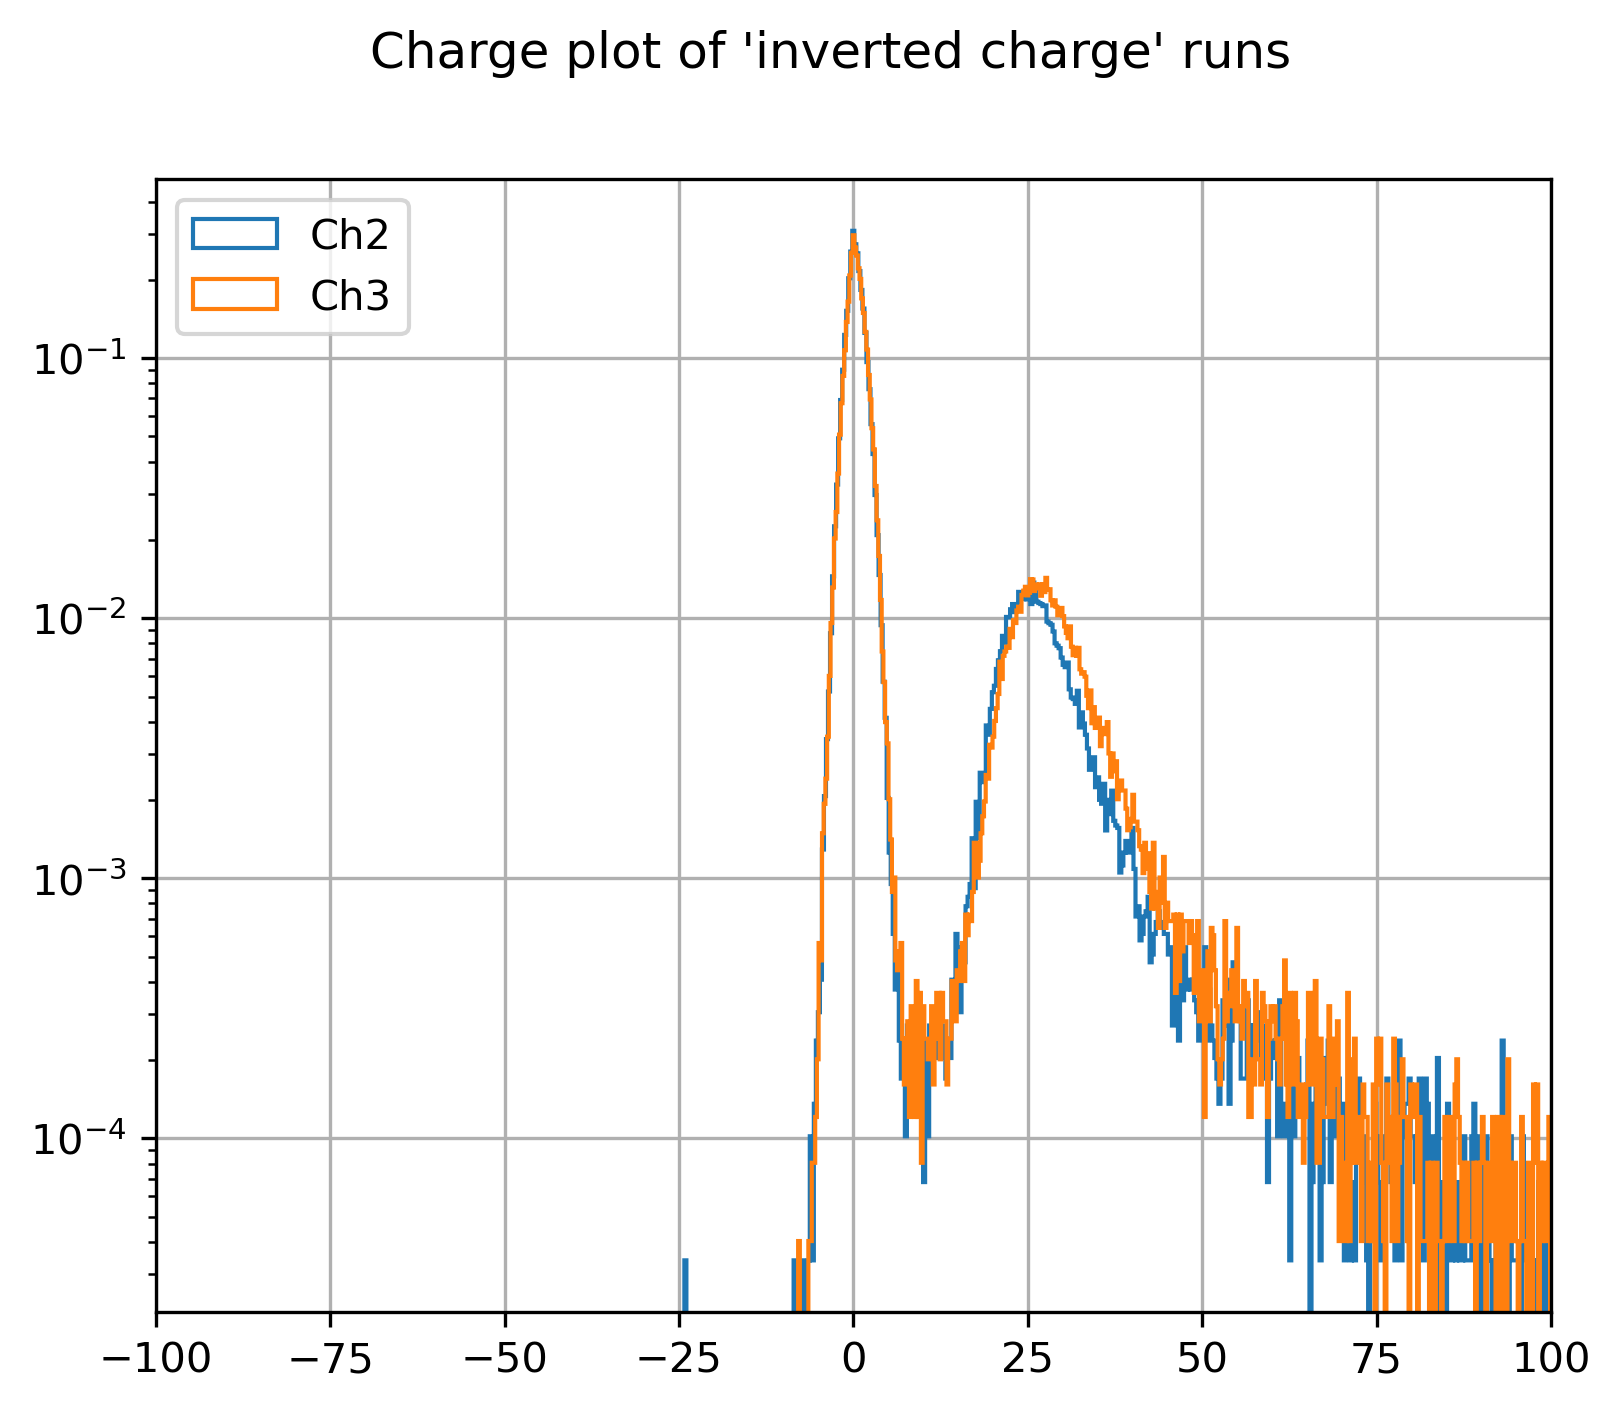

In [23]:
fig, ax = plt.subplots(figsize=(6,5), ncols=1, dpi=300)
for dut in DUTs:
    plot_histogram(df_run[f"charge_{dut}"]/4700, bins=2000, fig_ax=(fig,ax), label=f'Ch{dut+1}', density=True)
ax.semilogy()
ax.set_xlim(-100,100)
ax.legend()
fig.suptitle(f"Charge plot of 'inverted charge' runs")
print(df_run["eventNumber"].size)

101570


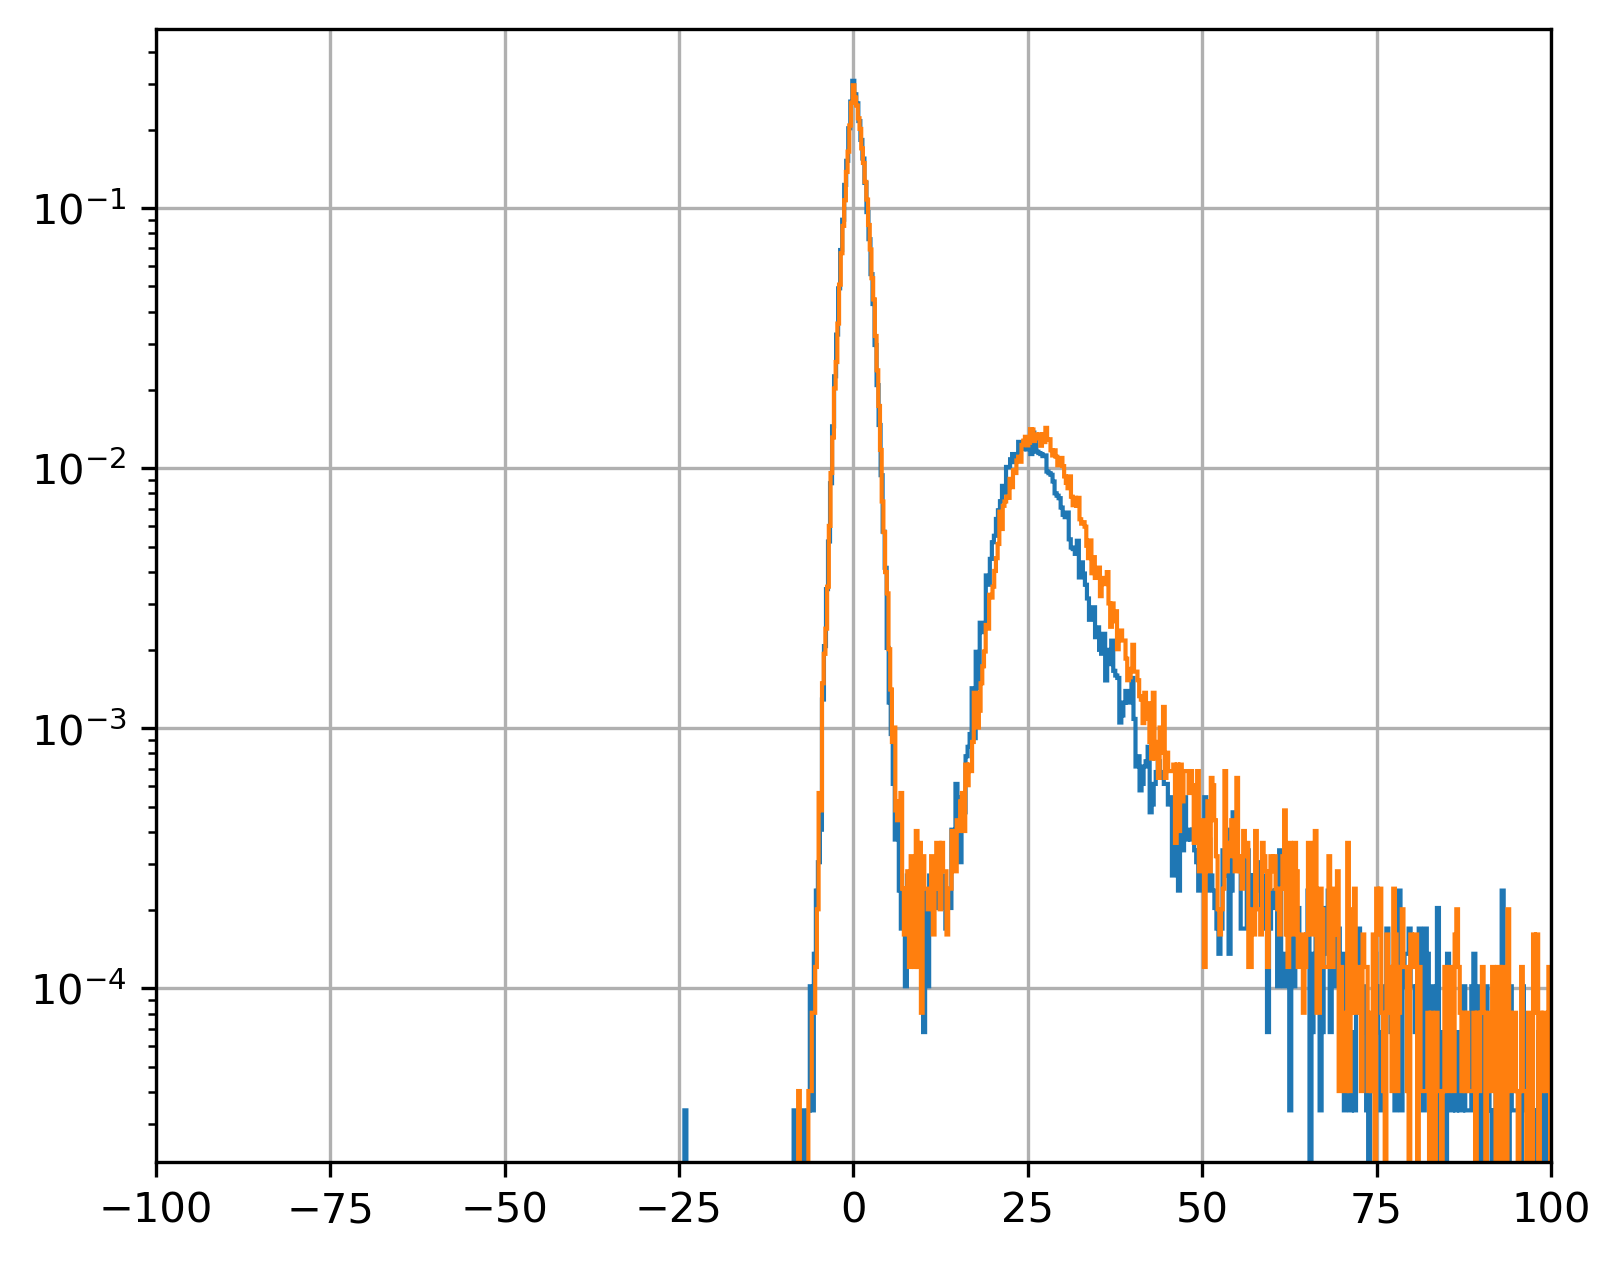

In [24]:
### repeat the same plot so I can quickly compare with the previous run
fig, ax = plt.subplots(figsize=(6,5), ncols=1, dpi=300)
for dut in DUTs:
    plot_histogram(df_run[f"charge_{dut}"]/4700, bins=2000, fig_ax=(fig,ax), density=True)
ax.semilogy()
ax.set_xlim(-100,100)
print(df_run["eventNumber"].size)

(<Figure size 1440x648 with 4 Axes>,
 array([<AxesSubplot:title={'center':'Ch3\nUSTC2.1-W17-P6-A'}, xlabel='pixels', ylabel='pixels'>],
       dtype=object))

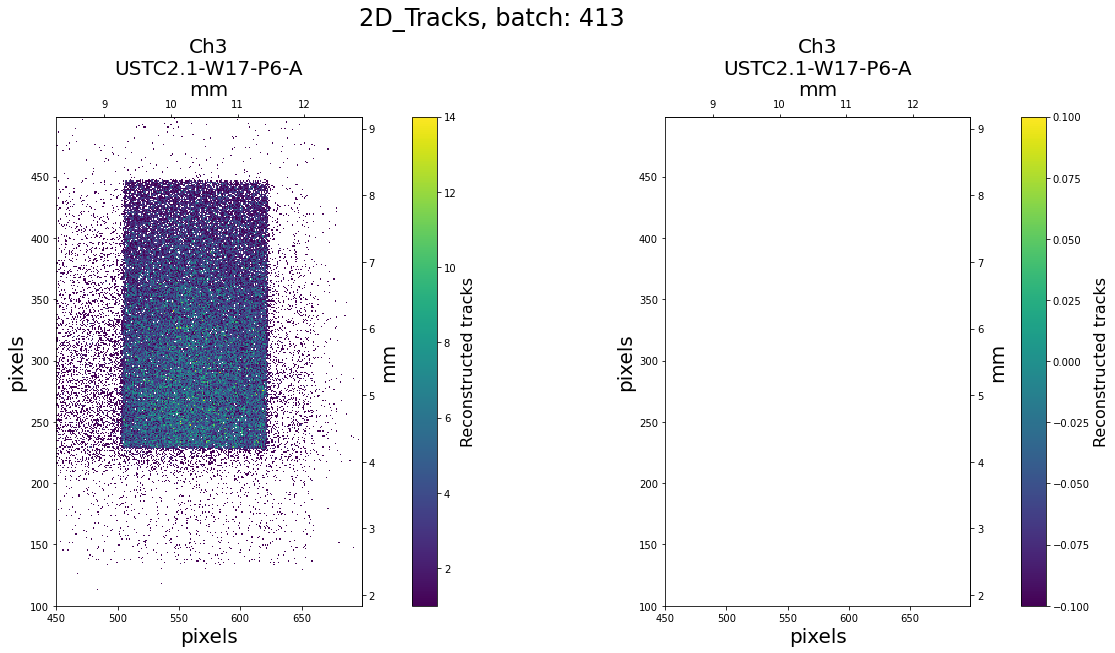

In [26]:
dut = 2
mask = df_run[f"charge_{dut}"]/4700 < -10
fig, axes = plt.subplots(figsize=(20,9), ncols=2)

plot(df_run, "2D_Tracks", dict_of_batches[this_batch], 'S1', bins=bins_dict[this_batch],
                 n_DUT=[dut], savefig=False, fig_ax=(fig,axes[0]))
plot(df_run, "2D_Tracks", dict_of_batches[this_batch], 'S1', bins=bins_dict[this_batch], mask=[mask,mask],
                 n_DUT=[dut], savefig=False, fig_ax=(fig,axes[1]))
# axes[0].set_title("no cuts",fontsize=20)

(<Figure size 1440x648 with 4 Axes>,
 array([<AxesSubplot:title={'center':'Ch2\nUSTC2.1-W17-P6-A'}, xlabel='pixels', ylabel='pixels'>],
       dtype=object))

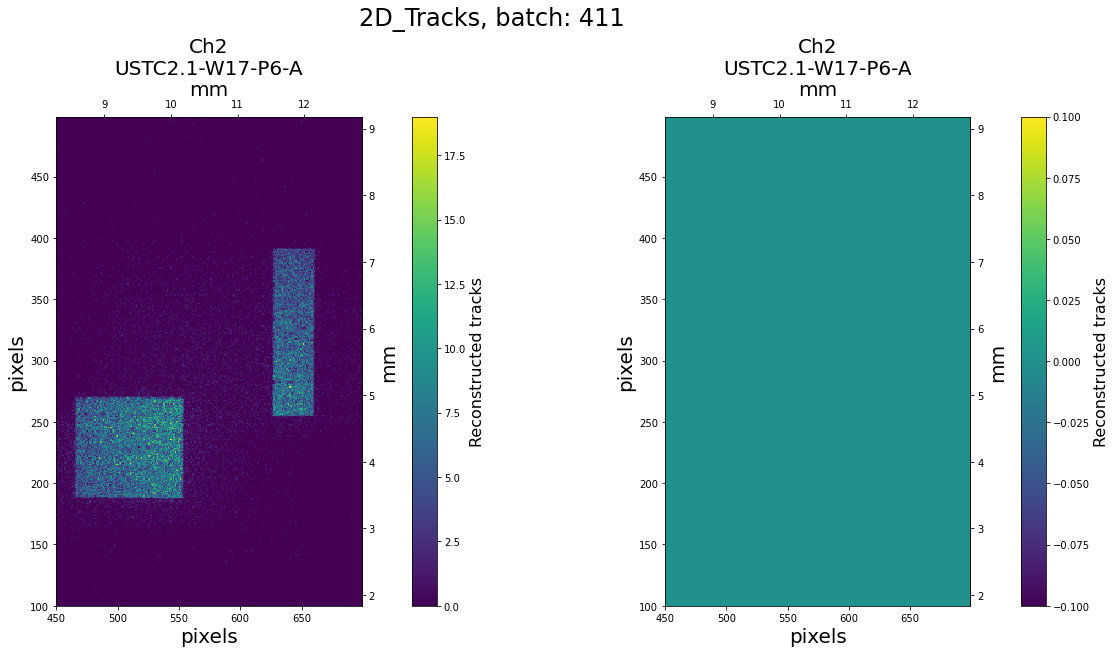

In [15]:
### repeated so I can quickly compare with the previous run
dut = 1
mask = df_run[f"charge_{dut}"]/4700 < -10
fig, axes = plt.subplots(figsize=(20,9), ncols=2)

plot(df_run, "2D_Tracks", dict_of_batches[this_batch], 'S1', bins=bins_dict[this_batch],
                 n_DUT=[dut], savefig=False, fig_ax=(fig,axes[0]))
plot(df_run, "2D_Tracks", dict_of_batches[this_batch], 'S1', bins=bins_dict[this_batch], mask=[mask],
                 n_DUT=[dut], savefig=False, fig_ax=(fig,axes[1]))
# axes[0].set_title("no cuts",fontsize=20)

[]

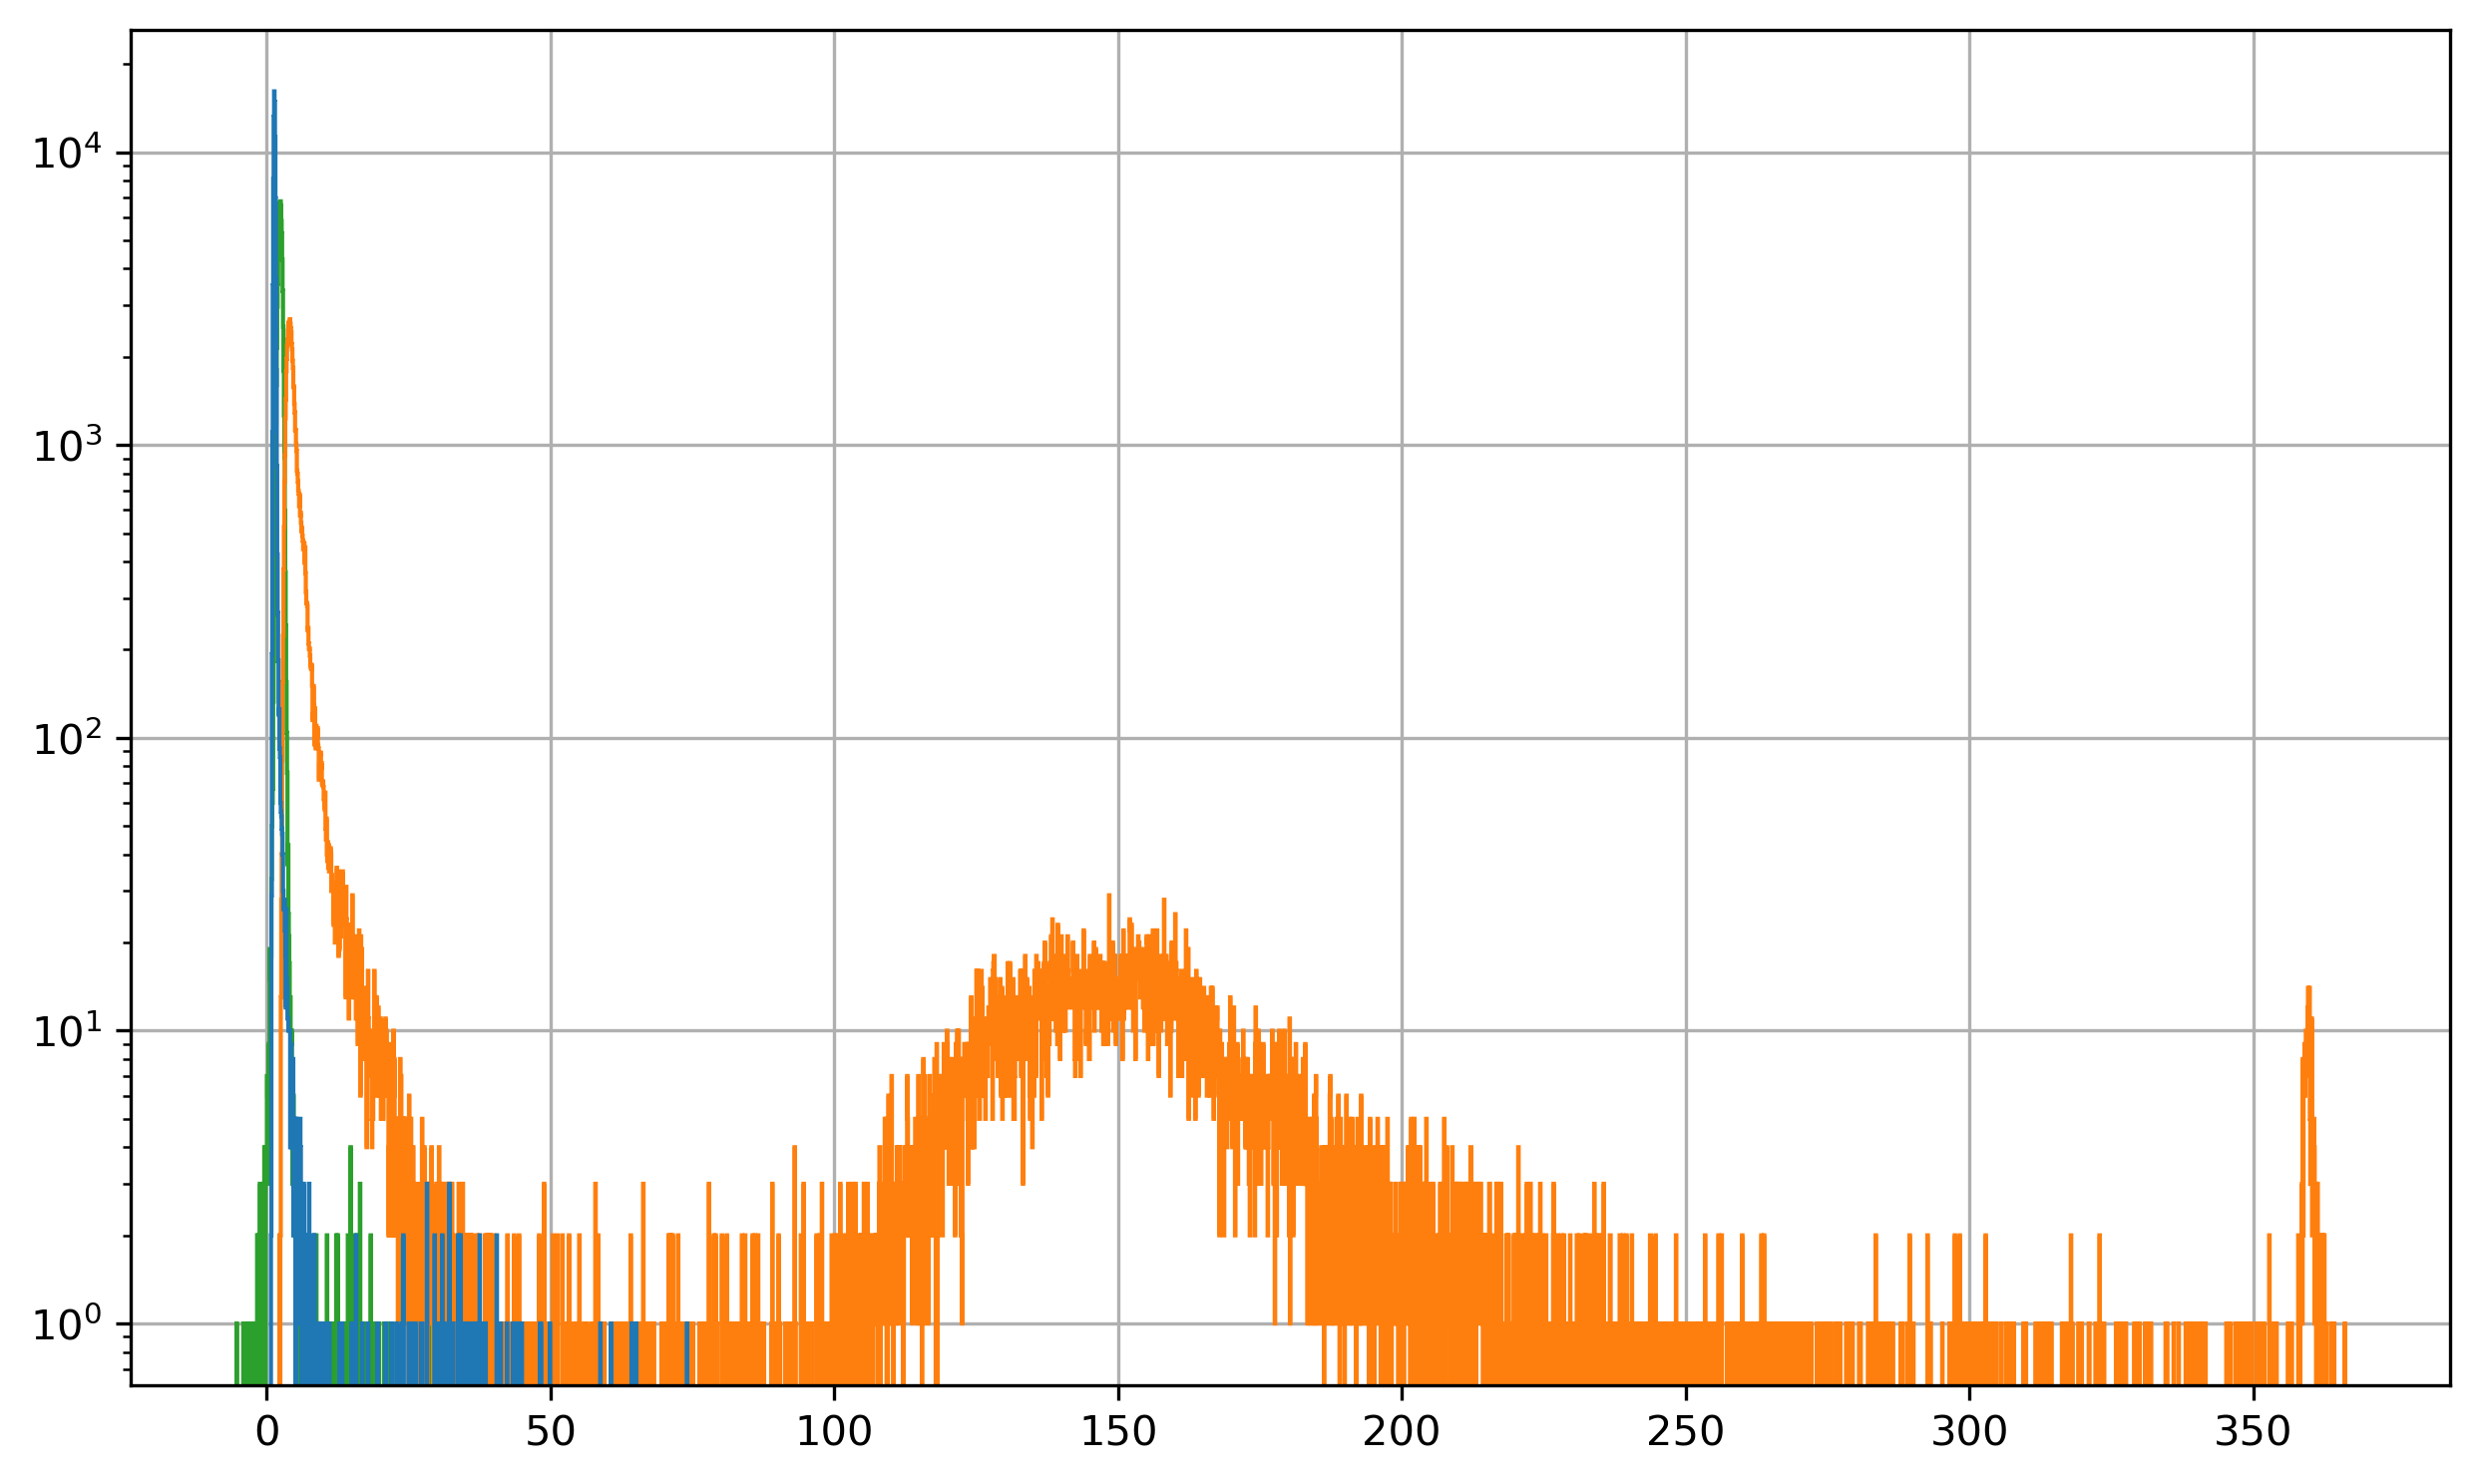

In [16]:
_,_,_,fig, ax = plot_histogram((df_run["noise_3"], df_run["pulseHeight_3"], df_run["pedestal_3"]))
ax.semilogy()
# ax.set_xlim(-2,200)


[]

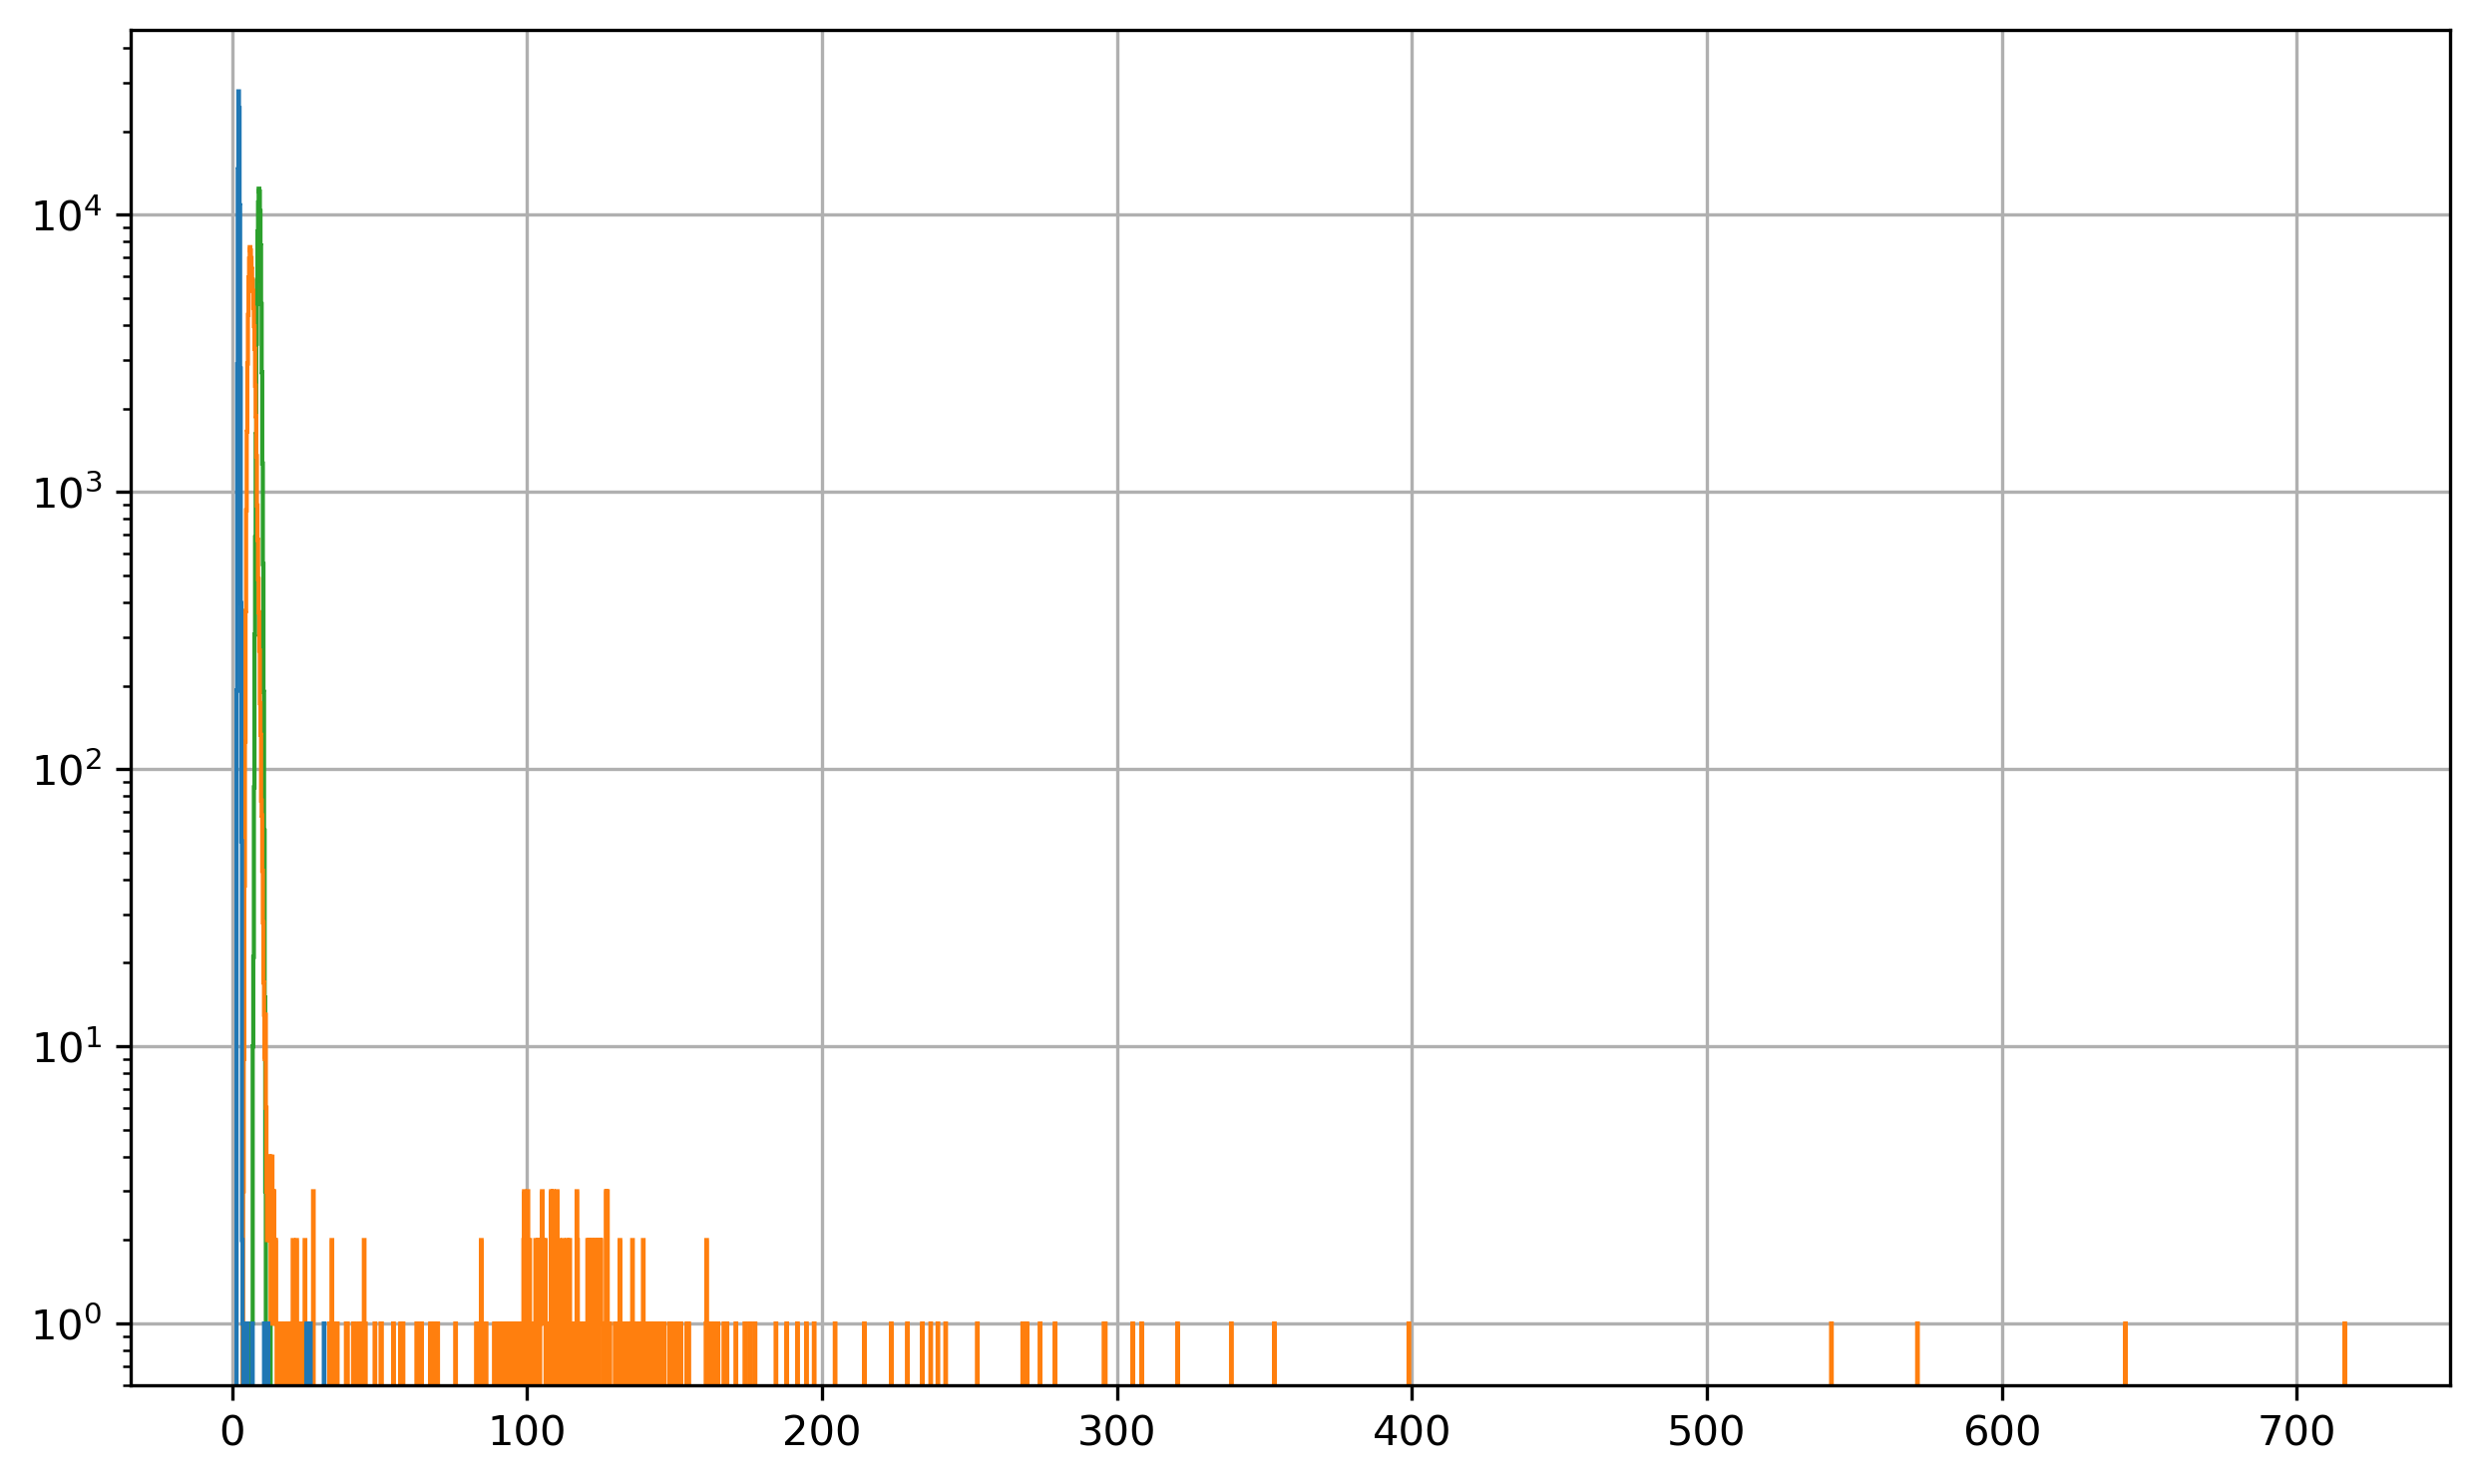

In [17]:
_,_,_,fig, ax = plot_histogram((df_run["noise_1"], df_run["pulseHeight_1"], df_run["pedestal_1"]))
ax.semilogy()
# ax.set_xlim(-2,200)


(0.0, 200.0)

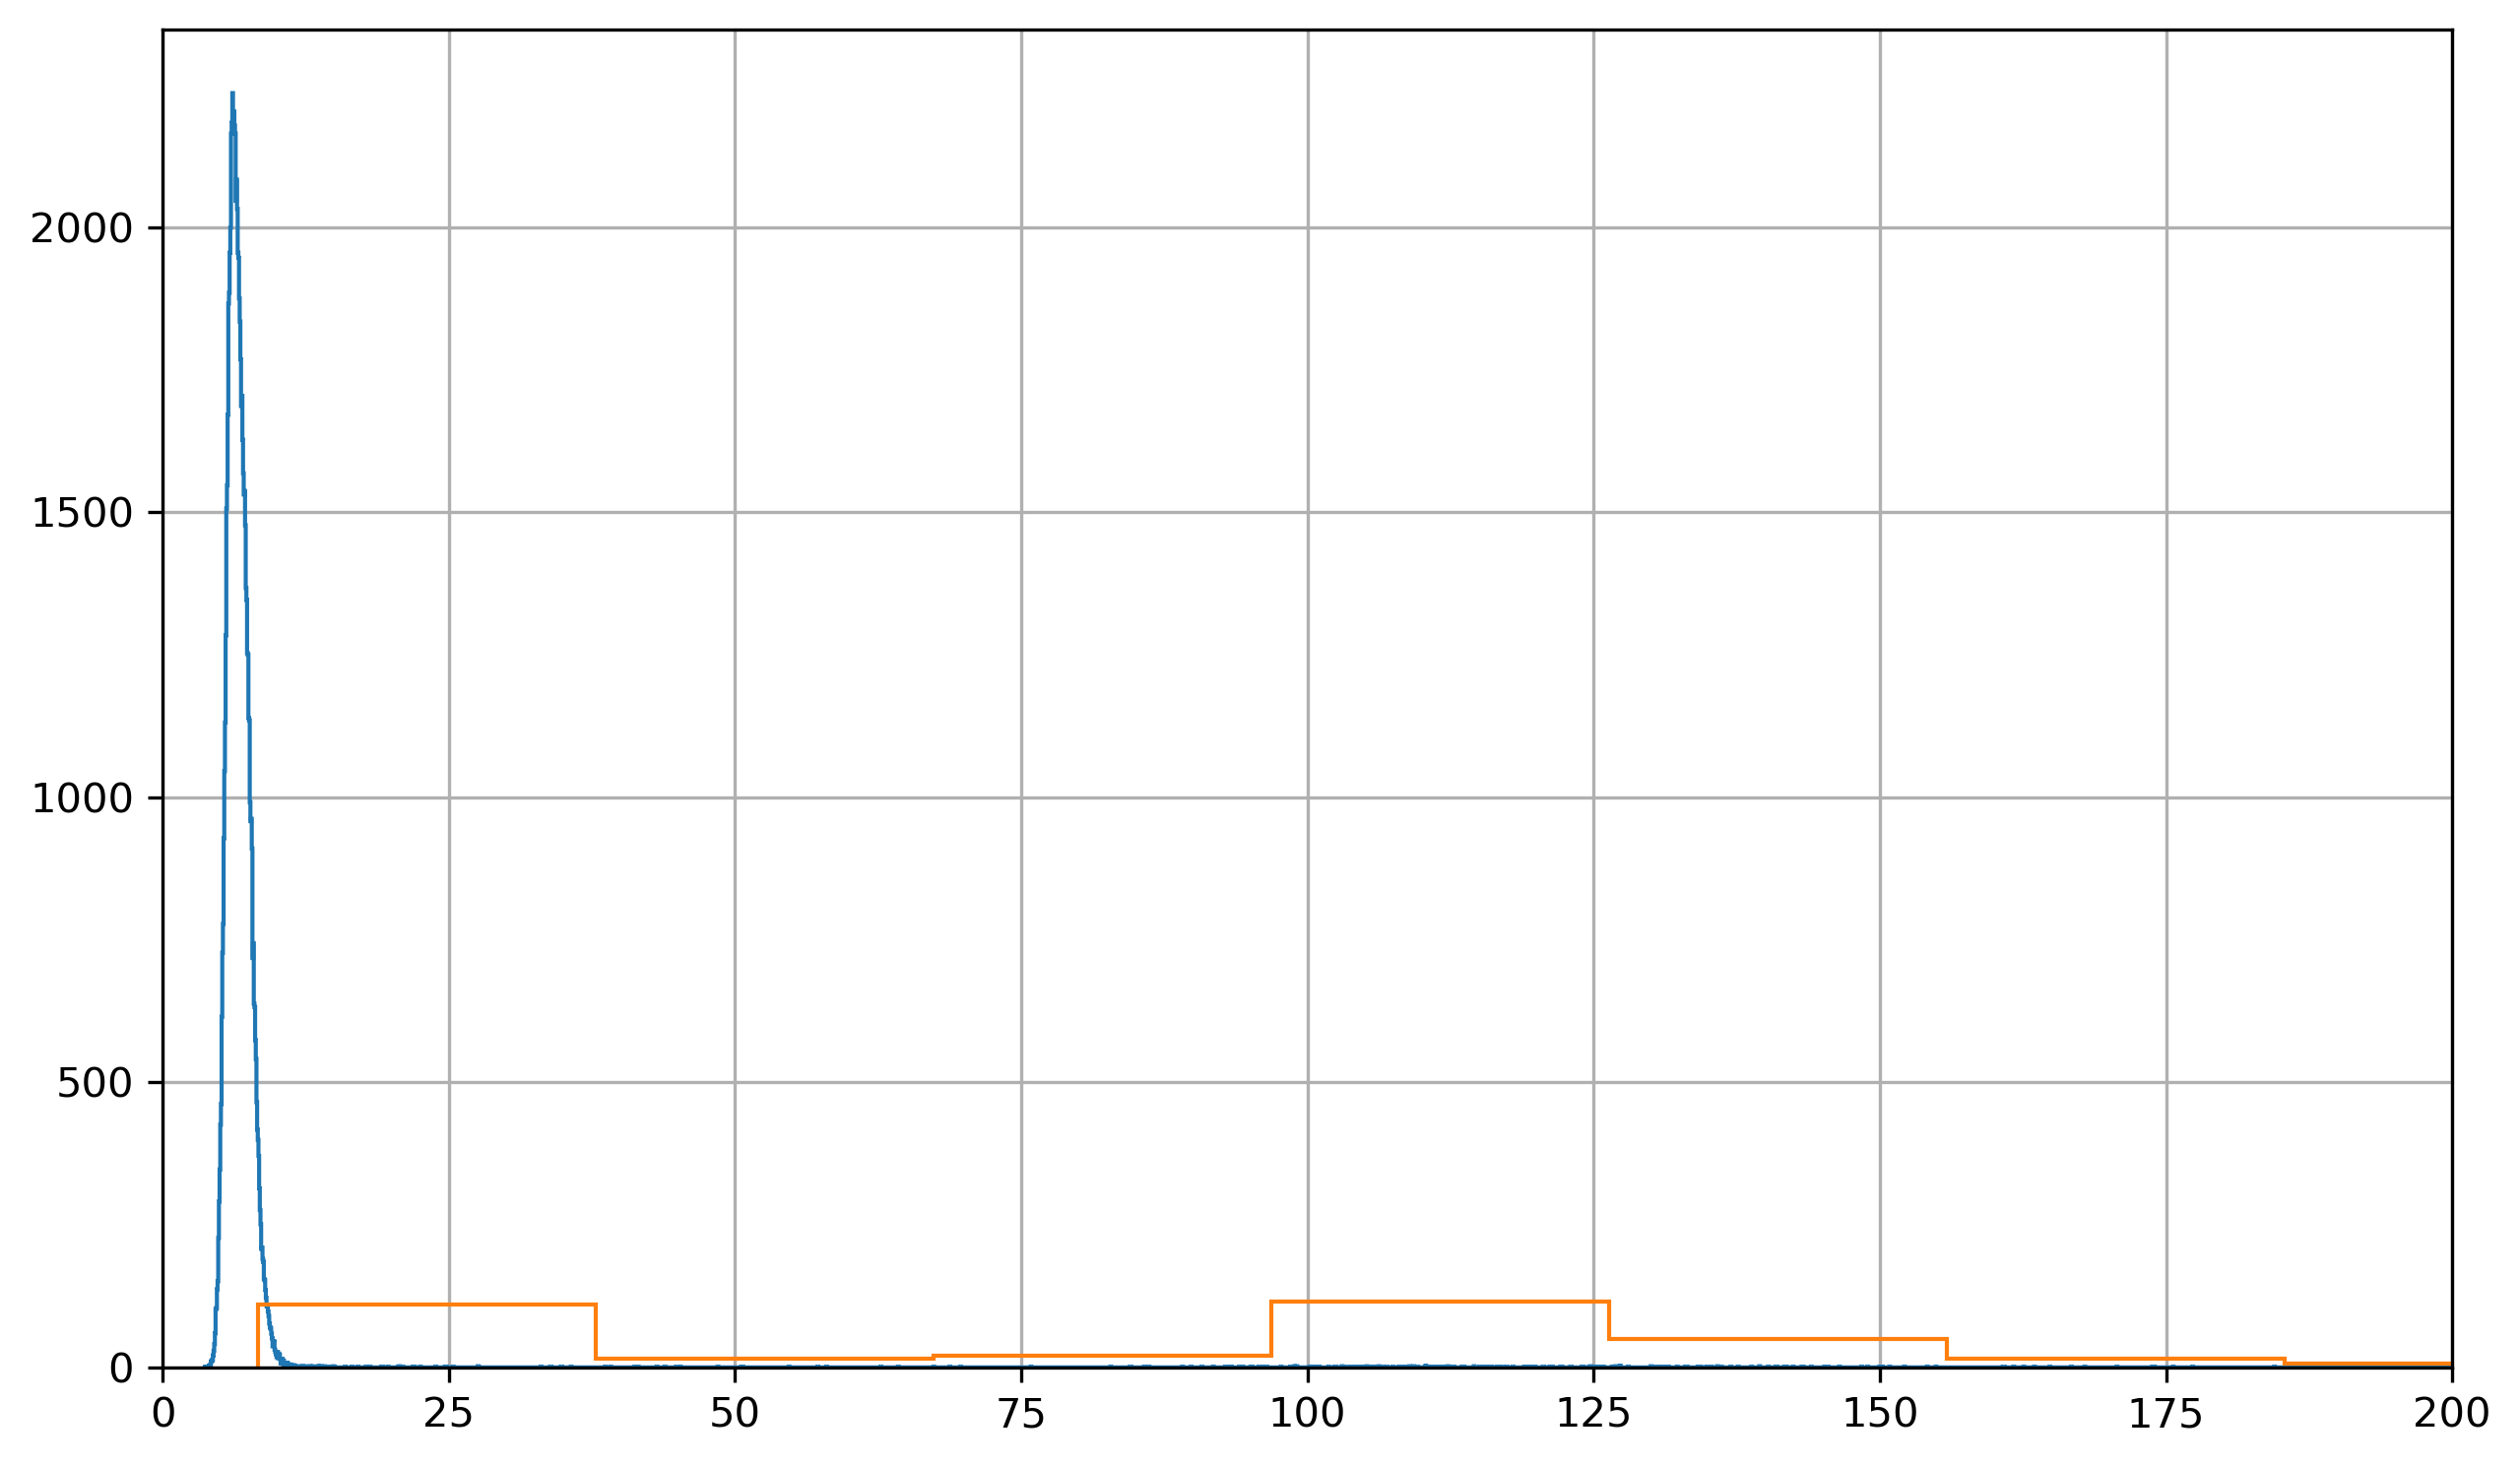

In [18]:
mask = df_run["pulseHeight_1"] > 5*df_run["noise_1"]

_,_,_,fig,ax = plot_histogram(df_run["pulseHeight_1"])
plot_histogram(df_run["pulseHeight_1"].loc[mask], fig_ax=(fig,ax))
ax.set_xlim(0,200)

In [19]:
fig, axes = plot(df[this_scope], "2D_Efficiency", dict_of_batches[this_batch], this_scope, bins=bins, geometry_cut='normal', zoom_to_sensor=True,
                 n_DUT=[1,2,3], threshold_charge=threshold_charge, savefig=False)

NameError: name 'this_scope' is not defined